## The University of Melbourne, School of Computing and Information Systems
# COMP90049 Introduction to Machine Learning, 2020 Semester 2
-----
## Project 1: Predicting stroke with Naive Bayes and K-NN
-----
###### Student Name(s):         Xulin Yang
###### Python version:           3.6.3
###### Submission deadline: 2020/09/11 17:00

This iPython notebook is a template which you will use for your Project 1 submission. 

Marking will be applied on the functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

## imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
import collections 
from collections import defaultdict
# K-NN implementation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics.pairwise import cosine_distances

In [2]:
DATA_FILE_PATH = "./stroke_update.csv"

## functions

### preprocess

In [3]:
# https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html
# Underweight   (0): BMI is less than 18.5
# Normal weight (1): BMI is 18.5 to 24.9
# Overweight    (2): BMI is 25 to 29.9
# Obese         (3): BMI is 30 or more
def bmi_categories(bmi):
    if bmi < 18.5:
        return 0
    elif 18.5 <= bmi < 24.9:
        return 1
    elif 24.9 <= bmi < 29.9:
        return 2
    else:
        return 3

# turn continous bmi to nominal bmi
def preprocess_bmi(data: pd.DataFrame):
    new_df = data.copy()
    new_df["bmi"] = new_df["bmi"].apply(lambda x: bmi_categories(x))
    
    return new_df

In [4]:
# age range from 10 to 82, so group size default by 50 and 
# remap age group [10-15, 15-20, ...] to [0, 1, 2, ...]
def age_categories(age, group_size=5):
    if age < 10:
        print("error: Unknown age", age)
    else:
        return age // group_size
#         age_group = (age // group_size) * group_size
#         return "[" + str(age_group) + "-" + str(age_group + group_size) + ")"

# turn continous age to nominal age group
def preprocess_age(data: pd.DataFrame):
    new_df = data.copy()
    new_df["age"] = new_df["age"].apply(lambda x: age_categories(x))
    
    return new_df

In [5]:
# glucose range from 55.01 to 271.74, so group size default by 50 and 
# remap age group [50-100, 100-150, ...] to [0, 1, 2, ...]
def glucose_categories(glucose, group_size=50):
    if glucose < 55.01 or glucose > 271.74:
        print("error: Unknown glucose", glucose)
    else:
        return glucose // group_size
#         glucose_group = (glucose // group_size) * group_size
#         return "[" + str(glucose_group) + "-" + str(glucose_group + group_size) + ")"

# turn continous glucose to nominal glucose group
def preprocess_glucose(data: pd.DataFrame):
    new_df = data.copy()
    new_df["avg_glucose_level"] = new_df["avg_glucose_level"].apply(lambda x: glucose_categories(x))
    
    return new_df

In [6]:
# This function transform continous attribute nominal attribute
def preprocess(data: pd.DataFrame):
    return preprocess_glucose(preprocess_bmi(preprocess_age(data)))

In [7]:
# convert binary: "No" or "Yes" to 0 or 1 respectively
def no_yes_to_0_1(data: pd.DataFrame, column_name: str):
    new_df = data.copy()
    new_df[column_name] = new_df[column_name].apply(lambda x: 0 if x=="No" else 1)
    
    return new_df

In [8]:
# convert binary: "No" or "Yes" to 0 or 1
def female_male_to_0_1(data: pd.DataFrame, column_name: str):
    new_df = data.copy()
    new_df[column_name] = new_df[column_name].apply(lambda x: 0 if x=="Female" else 1)
    
    return new_df

In [9]:
# convert 
# 'never smoked'   : 0
# 'formerly smoked': 1, 
# 'smokes'         : 2
smoking_status_dict = {'never smoked'   : 0,
                        'formerly smoked': 1, 
                        'smokes'         : 2
}

def smoking_status_to_012(data: pd.DataFrame):
    column_name = "smoking_status"
    new_df = data.copy()
    new_df[column_name] = new_df[column_name].apply(lambda x: smoking_status_dict[x])
    
    return new_df

In [10]:
# convert binary: 'Rural' or 'Urban' to 0 or 1 respectively
def rural_urban_to_0_1(data: pd.DataFrame, column_name: str):
    new_df = data.copy()
    new_df[column_name] = new_df[column_name].apply(lambda x: 0 if x=='Rural' else 1)
    
    return new_df

In [11]:
# convert 
# 'Never_worked' : 0,
# 'children'     : 1, 
# 'Self-employed': 2,
# 'Private'      : 3,
# 'Govt_job'     : 4
work_type_dict = {'Never_worked' : 0,
                        'children'     : 1, 
                        'Self-employed': 2,
                        'Private'      : 3,
                        'Govt_job'     : 4
}

def work_type_to_01234(data: pd.DataFrame):
    column_name = "work_type"
    new_df = data.copy()
    new_df[column_name] = new_df[column_name].apply(lambda x: work_type_dict[x])
    
    return new_df

In [12]:
# This function transform continous attribute nominal attribute
def preprocess2(data: pd.DataFrame):
    return work_type_to_01234(
        rural_urban_to_0_1(
            smoking_status_to_012(
                female_male_to_0_1(
                    no_yes_to_0_1(data, 
                                  "ever_married"
                                 ), "gender"
                )
            ), "Residence_type"
        )
    )

In [13]:
# convert 0 to No, 1 to Yes

yes_no_dict = {
    0: "No",
    1: "Yes"
}

def convert_0_1_to_No_Yes(data: pd.DataFrame, column_name: str):
    new_df = data.copy()
    new_df[column_name] = new_df[column_name].apply(lambda x: yes_no_dict[x])
    
    return new_df

In [14]:
def preprocess3(data: pd.DataFrame):
    return convert_0_1_to_No_Yes(
            convert_0_1_to_No_Yes(data, 
                                  "hypertension"
                                 ), 
        "heart_disease"
    )

### split_data

In [15]:
# This function should split a data set into a training set and hold-out test set
# k-fold applied here
def split_data(data: pd.DataFrame, k=10):
    kf = StratifiedKFold(n_splits=k)
    
    # assume class is the last attribute
    data_X, data_Y = data.iloc[:, 0:len(stroke_df.columns)-1], data.iloc[:, [-1]]
    
    for train_index, test_index in kf.split(data_X, data_Y):
        X_train, Y_train = data_X.iloc[train_index,:], data_Y.iloc[train_index,:]
        X_test,  Y_test  = data_X.iloc[test_index, :], data_Y.iloc[test_index, :]
        yield X_train, Y_train, X_test,  Y_test

In [16]:
# This function should build a supervised NB model
def train():
    return

In [17]:
# This function should predict the class for an instance or a set of instances, based on a trained model 
def predict():
    return

### evaluate

In [18]:
# This function should evaluate a set of predictions in terms of metrics
def evaluate(pred, true):
    CM = metrics.confusion_matrix(true, pred) # Confusion Matrix
    Acc = metrics.accuracy_score(true, pred) # Accuracy
    precf1 = metrics.precision_recall_fscore_support(true, pred, average='micro') # Precision, Recall and F1-score
    # 'micro', 'macro', 'weighted'
    return CM, Acc, precf1

### plot helper function

In [19]:
def scatter_with_stroke_class(data: pd.DataFrame, x_column: str):
    colors = ['r', 'b']
    stroke_class_values = [0, 1]
    
    plt.figure()
    for stroke_class in stroke_class_values:
        select_with_class = data[data["stroke"] == stroke_class]
        column = select_with_class[x_column]
        plt.scatter(np.array(column), select_with_class["stroke"], c=colors[stroke_class])
    plt.ylabel("stroke")
    plt.xlabel(x_column)
    plt.title(x_column + " v.s. stroke")
    plt.legend(stroke_class_values)
    plt.show()

In [20]:
def histgram_with_stroke_class(data: pd.DataFrame, x_column: str):
    colors = ['r', 'b']
    stroke_class_values = [0, 1]
    
    plt.figure()
    for stroke_class in stroke_class_values:
        select_with_class = data[data["stroke"] == stroke_class]
        column = select_with_class[x_column]
        plt.hist(column, log=True)
    
    plt.ylabel("stroke")
    plt.xlabel(x_column)
    plt.title(x_column + " v.s. stroke")
    plt.legend(stroke_class_values)
    plt.show()

## Questions (you may respond in a cell or cells below):

You should respond to questions 1-4. In question 2 (b) you can choose between two options. A response to a question should take about 100--200 words, and make reference to the data wherever possible.

## Question 1: Data exploration

### Question 1\a)
- a) Explore the data and summarise different aspects of the data. 
    - Can you see any interesting characteristic in features, classes or categories? 
    - What is the main issue with the data? 
    - Considering the issue, how would the Naive Bayes classifier work on this data? Discuss your answer based on the Naive Bayes' formulation. (3 marks)
    
<font color=blue>The answer for this question is shown in the following subsections.</font>

##### Attributes for the stroke_update.csv dataset:
    1. avg_glucose_level - patient's average Glucose level (Numeric: from 55.01 to 271.74)
    2. bmi - patient's body mass index (Numeric: from 11 to 70.3)
    3. age - patient's age (Numeric: from 10 to 82)
    4. gender - patient's gender (binary: "Female" or "Male")
    5. hypertension - Did patient have high blood pressure? (binary: "0" - No or "1" - Yes)
    6. heart_disease - Did patient have heart disease? (binary: "0" - No or "1" - Yes)
    7. ever_married - Have patient been ever married? (binary: "No" or "Yes")
    8. work_type - patient's job (nominal: 'Govt_job', 'Private', 'Self-employed', 'children', 'Never_worked')
    9. Residence_type - patient's residence (binary: 'Rural', 'Urban')
    10. smoking_status - patient's smoking history (nominal: 'formerly smoked', 'never smoked', 'smokes')

##### Class for the stroke_update.csv dataset:
    11 . stroke - Did patient have stroke? (binary: "0" - No or "1" - Yes)

#### read data

In [21]:
stroke_df = pd.read_csv(DATA_FILE_PATH)
stroke_df.sample(10)

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
228,73.94,37.5,62,Male,1,0,Yes,Private,Rural,never smoked,0
2652,70.16,25.9,65,Female,0,0,Yes,Self-employed,Rural,smokes,1
319,114.35,30.3,33,Female,0,0,Yes,Private,Rural,never smoked,0
65,84.36,31.9,57,Male,0,0,Yes,Private,Rural,never smoked,0
1512,93.73,31.8,40,Male,0,0,Yes,Govt_job,Rural,never smoked,0
285,112.30,23.2,49,Female,0,0,Yes,Govt_job,Rural,never smoked,0
127,87.39,57.9,39,Female,0,0,Yes,Private,Urban,never smoked,0
2408,99.81,33.3,64,Male,0,0,Yes,Private,Urban,formerly smoked,1
249,85.89,31.9,56,Female,0,0,Yes,Private,Urban,never smoked,0
1338,234.90,30.6,73,Male,0,0,Yes,Govt_job,Rural,formerly smoked,0


#### check missing value

In [22]:
stroke_df.isnull().sum()

avg_glucose_level    0
bmi                  0
age                  0
gender               0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
smoking_status       0
stroke               0
dtype: int64

<font color=blue>As you can see from the above code, there is no missing value in the data set. Which means we don't need to do any imputation.</font>

#### inspect class distribution

0    0.8
1    0.2
Name: stroke, dtype: float64

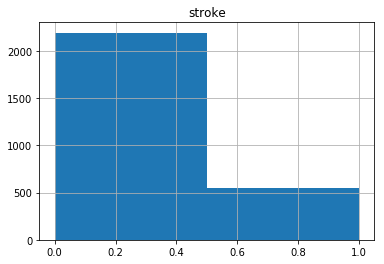

In [23]:
stroke_df.hist(column="stroke", bins=2)
stroke_df["stroke"].value_counts() / stroke_df["stroke"].count()

<font color=blue>As you can see from the above code, the distribution of the given data's stroke class is not even. 80% of the instances are no stroke (value = 0).</font>

#### inspect non-numeric attribute distribution

In [24]:
# helper function to calculate attribute's value distribution
def inspect_attribute_distribution(data: pd.DataFrame, column_name: str):
    values = list(set(data[column_name]))
    
    stroke_class_values = [0, 1]
    
    summary = pd.DataFrame(data[column_name].value_counts() / data[column_name].count())
    summary = summary.rename(columns={summary.columns[-1]: "stroke_all_" + summary.columns[-1]})
    
    for stroke_class in stroke_class_values:
        data_filtered = data[stroke_df_preprocess3["stroke"] == stroke_class]
        
        tmp = pd.DataFrame(data_filtered[column_name].value_counts() / data_filtered[column_name].count())

        summary = pd.concat([summary, tmp], axis=1)        
        summary = summary.rename(columns={summary.columns[-1]: 
                                          "stroke_" + yes_no_dict[stroke_class] + "_" + summary.columns[-1]
                                         }
                                )
    
    return summary

In [25]:
stroke_df_preprocess3 = preprocess3(stroke_df)
stroke_class_values = [0, 1]

summaries = []

for c in stroke_df_preprocess3.columns[3:len(stroke_df_preprocess3.columns)-1]:
    summaries.append(inspect_attribute_distribution(stroke_df_preprocess3, c))

In [26]:
summaries[0]

,stroke_all_gender,stroke_No_gender,stroke_Yes_gender
Female,0.605474,0.614051,0.571168
Male,0.394526,0.385949,0.428832


<font color=blue>As you can see from the above, the gender attribute is not so even among all instances (60% v.s. 40%). And the distribution is maintained for both stroke classes.</font>

In [27]:
summaries[1]

,stroke_all_hypertension,stroke_No_hypertension,stroke_Yes_hypertension
No,0.848175,0.882755,0.709854
Yes,0.151825,0.117245,0.290146


<font color=blue>As you can see from the above, the hypertension attribute is not so even among all instances (85% v.s. 15%). And the distribution is maintained for no stroke class. The distribution has a change for has stroke classes. 18% higher for No hypertension when no stroke compared to has hypertension when has stroke.</font>

In [28]:
summaries[2]

,stroke_all_heart_disease,stroke_No_heart_disease,stroke_Yes_heart_disease
No,0.918978,0.953923,0.779197
Yes,0.081022,0.046077,0.220803


<font color=blue>As you can see from the above, the heart_disease attribute is not so even among all instances (92% v.s. 8%). And the distribution is maintained for no stroke class. The distribution has a change for has stroke classes. 17% higher for No heart_disease when no stroke compared to has heart_disease when has stroke.</font>

In [29]:
summaries[3]

,stroke_all_ever_married,stroke_No_ever_married,stroke_Yes_ever_married
Yes,0.760949,0.72719,0.895985
No,0.239051,0.27281,0.104015


<font color=blue>As you can see from the above, the ever_married attribute is not so even among all instances (76% v.s. 23%). And the distribution is maintained for no stroke class. The distribution has a change for has stroke classes. 12% lower for Not ever_married when no stroke compared to has ever_married when has stroke.</font>

In [30]:
summaries[4].fillna(0)  # replace NaN with 0 to make sense

,stroke_all_work_type,stroke_No_work_type,stroke_Yes_work_type
Govt_job,0.133577,0.136861,0.120438
Never_worked,0.002190,0.002737,0.000000
Private,0.635766,0.652828,0.567518
Self-employed,0.210584,0.185219,0.312044
children,0.017883,0.022354,0.000000


<font color=blue>As you can see from the above, the work_type attribute is not so even among all instances (lowest is 0.2% highest is 64%). And the distribution is maintained for no stroke class. The distribution has a change for has stroke classes. 22% lower for Self-employed when no stroke compared to Self-employed when has stroke. And when has stroke, we have 0% for Never_worked and children. This might mean our sample size might not be big enough to cover this case.</font>

In [31]:
summaries[5]

,stroke_all_Residence_type,stroke_No_Residence_type,stroke_Yes_Residence_type
Urban,0.505839,0.505018,0.509124
Rural,0.494161,0.494982,0.490876


<font color=blue>As you can see from the above, the Residence_type attribute is even among all instances (about 50%). And the distribution is maintained for both stroke classes.</font>

In [32]:
summaries[6]

,stroke_all_smoking_status,stroke_No_smoking_status,stroke_Yes_smoking_status
never smoked,0.514964,0.526916,0.467153
formerly smoked,0.264599,0.248631,0.328467
smokes,0.220438,0.224453,0.204380


<font color=blue>As you can see from the above, the smoking_status attribute is not so even among all instances (lowest is 22% highest is 51%). And the distribution is maintained for no stroke class. The distribution has a change for has stroke classes. 8% lower for formerly smoked when no stroke compared to formerly smoked when has stroke. </font>

#### boxplot numeric attributes

##### avg_glucose_level all instance

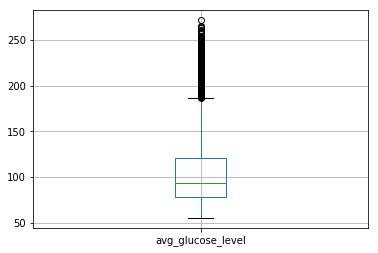

In [33]:
stroke_df.boxplot(column="avg_glucose_level")

In [34]:
quantile1, quantile3 = stroke_df["avg_glucose_level"].quantile([0.25, 0.75]).values
iqr = quantile3 - quantile1

# sample 25 out of 401
stroke_df[stroke_df["avg_glucose_level"] > quantile3 + 1.5 * iqr].sample(25)

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
744,234.15,24.4,71,Female,0,0,Yes,Private,Rural,smokes,0
1550,216.02,34.1,82,Male,0,0,No,Self-employed,Urban,never smoked,0
2488,206.74,30.9,80,Female,0,0,Yes,Self-employed,Rural,formerly smoked,1
226,218.04,34.1,56,Female,1,1,Yes,Govt_job,Rural,never smoked,0
2348,205.33,31.0,79,Female,0,1,No,Private,Urban,smokes,1
1605,224.34,26.6,56,Female,0,0,Yes,Self-employed,Rural,formerly smoked,0
2618,220.98,28.5,65,Male,0,0,Yes,Private,Urban,smokes,1
1296,224.63,42.8,56,Female,0,0,Yes,Self-employed,Urban,never smoked,0
897,199.60,25.1,77,Male,0,0,Yes,Govt_job,Rural,smokes,0
2478,216.62,38.2,62,Female,0,0,Yes,Private,Rural,never smoked,1


<font color=blue>As you can see from the above, there are 401 outlier for avg_glucose_level attribute in all instances.</font>

##### avg_glucose_level by stroke class

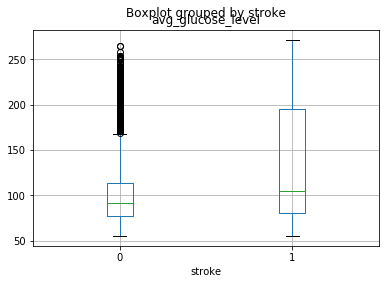

In [35]:
stroke_df.boxplot(column="avg_glucose_level",by='stroke')

<font color=blue>As you can see from the above, there are no outlier for avg_glucose_level attribute in has stroke class. But we have 294 outliers in has stroke class which is:</font>

In [36]:
no_stroke_df = stroke_df[stroke_df["stroke"] == 0]

quantile1, quantile3 = no_stroke_df["avg_glucose_level"].quantile([0.25, 0.75]).values
iqr = quantile3 - quantile1

# sample 25 out of 294
no_stroke_df[no_stroke_df["avg_glucose_level"] > quantile3 + 1.5 * iqr].sample(25)

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
370,226.42,39.1,52,Female,0,0,Yes,Private,Urban,never smoked,0
1850,181.17,59.7,67,Female,0,0,Yes,Self-employed,Rural,formerly smoked,0
2000,218.72,32.3,43,Female,0,0,Yes,Private,Urban,never smoked,0
812,222.53,28.5,78,Female,1,0,No,Private,Urban,never smoked,0
817,191.28,40.6,57,Female,1,0,Yes,Govt_job,Urban,never smoked,0
662,175.68,26.1,35,Male,0,0,Yes,Private,Rural,never smoked,0
328,212.87,34.8,70,Female,0,0,Yes,Private,Rural,never smoked,0
1149,187.22,29.2,78,Male,0,0,Yes,Self-employed,Urban,never smoked,0
1872,171.05,37.7,67,Female,1,0,Yes,Govt_job,Urban,never smoked,0
1389,175.73,42.4,32,Female,0,0,No,Self-employed,Rural,formerly smoked,0


##### bmi all instance

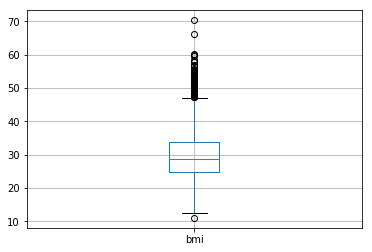

In [37]:
stroke_df.boxplot(column="bmi")

In [38]:
quantile1, quantile3 = stroke_df["bmi"].quantile([0.25, 0.75]).values
iqr = quantile3 - quantile1

# sample 25 out of 70
stroke_df[stroke_df["bmi"] > quantile3 + 1.5 * iqr].sample(25)

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
542,87.03,55.2,53,Female,1,0,Yes,Private,Urban,formerly smoked,0
987,204.92,49.6,66,Female,0,1,Yes,Private,Urban,formerly smoked,0
1492,128.00,47.6,35,Female,0,0,Yes,Govt_job,Rural,never smoked,0
1724,97.88,47.7,35,Female,0,0,Yes,Private,Rural,never smoked,0
2673,193.62,48.7,51,Male,1,1,Yes,Private,Urban,formerly smoked,1
66,70.70,48.1,22,Female,0,0,No,Private,Rural,formerly smoked,0
955,83.78,54.9,21,Male,0,0,No,Private,Urban,never smoked,0
2560,70.41,47.6,43,Male,0,0,Yes,Private,Rural,never smoked,1
2081,207.98,53.8,64,Female,1,0,Yes,Self-employed,Rural,formerly smoked,0
1100,104.28,49.1,48,Female,0,0,Yes,Private,Rural,never smoked,0


In [39]:
stroke_df[stroke_df["bmi"] < quantile1 - 1.5 * iqr]

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
1949,81.5,11.0,49,Male,0,0,Yes,Private,Urban,never smoked,0


<font color=blue>As you can see from the above, there are 71 outlier for bmi attribute in all instances.</font>

##### bmi by stroke class

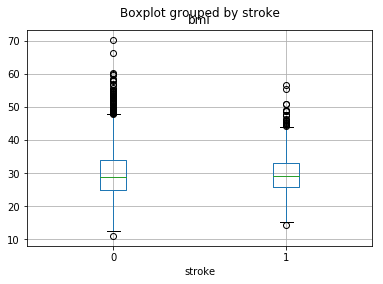

In [40]:
stroke_df.boxplot(column="bmi",by='stroke')

<font color=blue>As you can see from the above, there are outliers for bmi attribute when grouped by stroke class.</font>

In [41]:
outliers = []

for c in [0, 1]:
    filtered_stroke_df = stroke_df[stroke_df["stroke"] == c]

    quantile1, quantile3 = filtered_stroke_df["bmi"].quantile([0.25, 0.75]).values
    iqr = quantile3 - quantile1

    outliers.append(filtered_stroke_df[filtered_stroke_df["bmi"] < quantile1 - 1.5 * iqr])
    outliers.append(filtered_stroke_df[filtered_stroke_df["bmi"] > quantile3 + 1.5 * iqr])

<font color=blue>Following are the outliers for stroke=0 class.</font>

In [42]:
outliers[0]

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
1949,81.5,11.0,49,Male,0,0,Yes,Private,Urban,never smoked,0


In [43]:
outliers[1]

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
43,59.70,49.3,23,Female,0,0,No,Private,Urban,formerly smoked,0
64,223.39,58.4,55,Male,1,0,Yes,Self-employed,Urban,never smoked,0
66,70.70,48.1,22,Female,0,0,No,Private,Rural,formerly smoked,0
93,171.42,59.9,54,Female,1,0,Yes,Private,Urban,never smoked,0
97,87.17,51.8,44,Male,1,0,No,Private,Rural,formerly smoked,0
101,83.00,48.9,29,Female,0,0,No,Private,Rural,smokes,0
127,87.39,57.9,39,Female,0,0,Yes,Private,Urban,never smoked,0
293,84.27,55.8,37,Female,0,0,Yes,Private,Rural,never smoked,0
299,63.89,53.8,33,Female,0,0,No,Private,Rural,formerly smoked,0
320,170.53,52.4,66,Female,0,0,Yes,Private,Urban,formerly smoked,0


<font color=blue>Following are the outliers for stroke=1 class.</font>

In [44]:
outliers[2]

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
2530,126.46,14.3,82,Male,0,1,Yes,Self-employed,Rural,never smoked,1


In [45]:
outliers[3]

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
2208,233.29,48.9,52,Female,1,0,Yes,Self-employed,Urban,never smoked,1
2214,212.08,44.2,57,Male,1,0,Yes,Private,Urban,smokes,1
2241,221.58,47.5,70,Female,0,0,Yes,Private,Urban,never smoked,1
2274,224.10,56.6,45,Female,0,0,Yes,Private,Rural,never smoked,1
2310,203.87,45.7,78,Female,1,0,No,Private,Urban,never smoked,1
2318,64.44,45.0,80,Female,0,0,Yes,Private,Urban,never smoked,1
2328,205.77,46.0,65,Female,0,0,Yes,Private,Urban,formerly smoked,1
2334,242.52,45.5,70,Male,1,0,Yes,Private,Rural,formerly smoked,1
2399,82.68,45.2,78,Female,0,0,Yes,Private,Rural,never smoked,1
2560,70.41,47.6,43,Male,0,0,Yes,Private,Rural,never smoked,1


##### age all instance

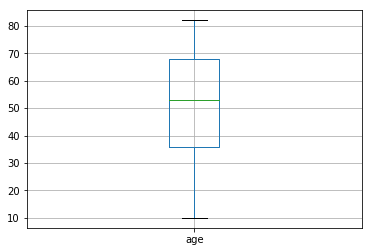

In [46]:
stroke_df.boxplot(column="age")

<font color=blue>As you can see from the above, there are no outlier for age attribute in all instances.</font>

##### age by stroke class

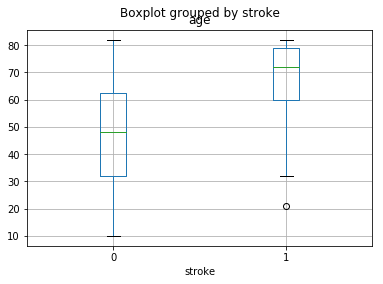

In [47]:
stroke_df.boxplot(column="age",by='stroke')

<font color=blue>As you can see from the above, there are no outlier for age attribute in no stroke class. But we have on outlier in has stroke class which is:</font>

In [48]:
stroke_df[stroke_df["stroke"] == 1][stroke_df["age"] < 30]

d:\python\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
2380,67.42,25.7,21,Male,0,0,No,Private,Rural,never smoked,1


#### parallel plot of attributes by class

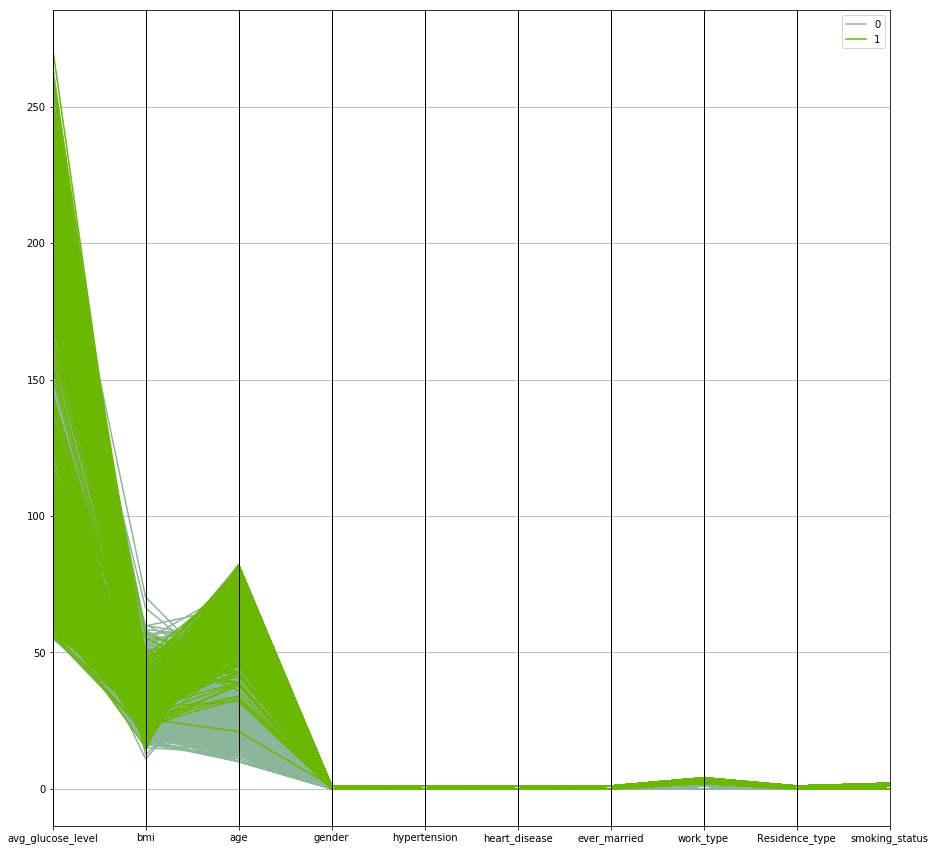

In [49]:
stroke_df_preprocess = preprocess2(stroke_df)
plt.figure(figsize=(15, 15))
pd.plotting.parallel_coordinates(stroke_df_preprocess, cols=stroke_df_preprocess.columns[:-1], class_column="stroke")
plt.show()

#### pair plot of attributed by class

- Note: I mention the below pair plot in a 0-based index from top corner; "diagram 0-1" is for the diagram in row 0 and column 1 in the scatter_matrix figure
- Note: I will make larger diagram as shown in the below pair plot in the discussion.
- As you can see from the scatter_matrix figure:

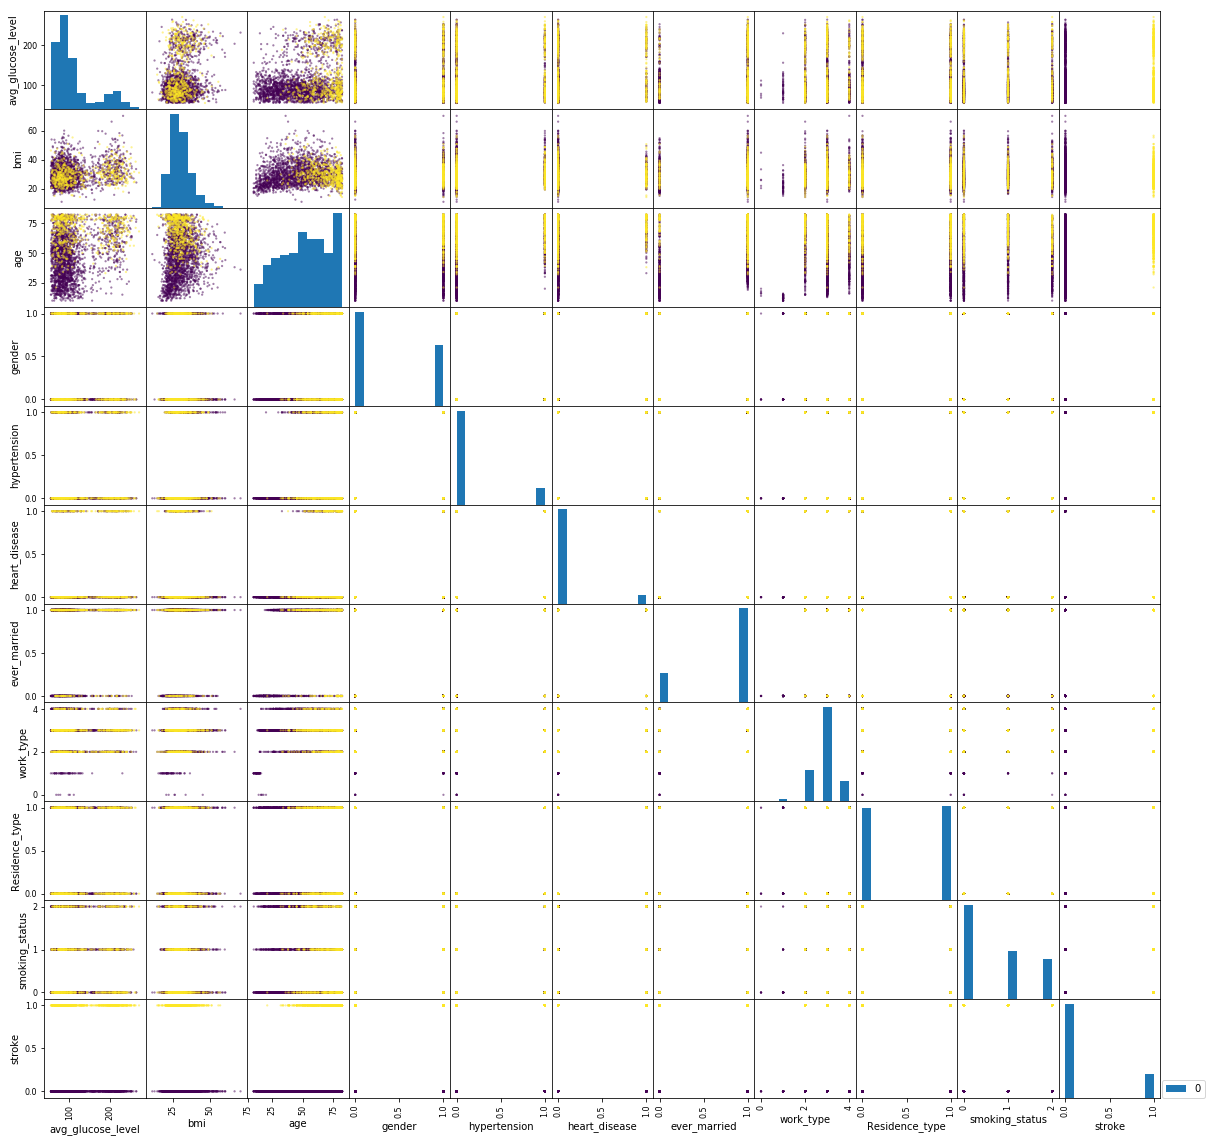

In [50]:
stroke_df_preprocess = preprocess2(stroke_df)
g = pd.plotting.scatter_matrix(stroke_df_preprocess,
                               alpha=0.5, 
                               figsize=(20, 20), 
                               c=stroke_df_preprocess["stroke"], 
                               marker='o', 
                               s=5,
                               range_padding=0.15,
                              )
plt.legend([0, 1], loc=(1.02,0))
plt.show()

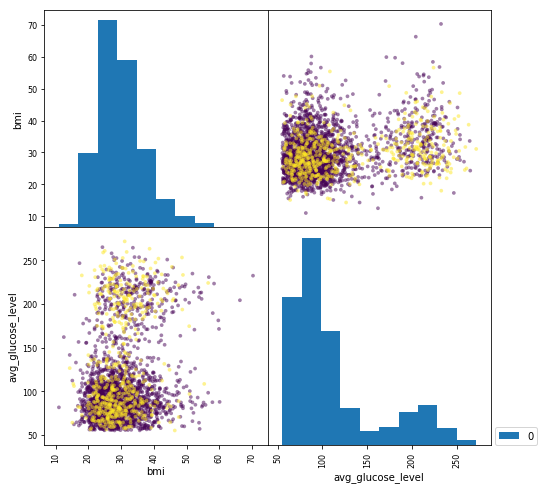

In [51]:
stroke_df_preprocess = preprocess2(stroke_df)
g = pd.plotting.scatter_matrix(stroke_df_preprocess.loc[:, ["bmi", "avg_glucose_level"]], 
                               alpha=0.5, 
                               figsize=(8, 8), 
                               c=stroke_df_preprocess["stroke"], 
                               marker='o', 
                               s=14,
                               range_padding=0.15,
                              )
plt.legend([0, 1], loc=(1.02,0))
plt.show()

- the bottom left one is larger diagram 1-0
- From diagram 1-0: We can't differ whether stroke or not by looking at "bmi" with "patient's average Glucose level" as there is no clear pattern to distinguishing stroke class. The scatter points are mixed together.


    - From diagram 2-0: There is some correlation between "age" and "patient's average Glucose level". Because we can see a clear pattern that young people seems rarely have high glucose level or this suggests there are some missing data here.
    - From diagram 2-1: 

### Question 1\b)
- b) Is accuracy an appropriate metric to evaluate the models created for this data? Justify your answer. Explain which metric(s) would be more appropriate, and contrast their utility against accuracy. [no programming required] (2 marks)

Accuracy is not the most appropriate metric to evaluate the models created for this data. The reason is that simply looking the #correct_prediction / #instances is not enough. For this data set, the class we would like to predict is 0: no stroke and 1: stroke. For example, if we have a stroker sensor for the alarm, we care the correctness of **has stroke** prediction. From the below model1 example, although we have good accuracy, the model is meaningless (useless) for predicting all has_stroke wrongly which we interested. As a result, we might be interested in #correct_has_stroke_prediction / #actual_has_stroke_instances (precision). Precision measures how often are we correct when we predict that an instance is interesting (has_stroke in this example). Symmetrically, we also want to know #correct_has_stroke_prediction / #prediction_of_has_stroke (recall). Recall measures what proportion of the truly interesting instances have we correctly identified as interesting. So the "accuracy metric" is not the most appropriate here. 

The other candidate metrics here are: **precision, recall, f-score**. First two are describe above and both of them are typically in an inverse relationship, f-score is a measurement that represents both of them. F-score gives more weight to false negatives and false positives while not letting large numbers of true negatives influence your score. For example, we have 3 models: 
- model1: predict every instance as 0
- model2: predict every instance as 1 
- model3: predict half of actual has_stroke correctly and all of actual no_stroke correctly 

Then we construct following confusion matrix:

|model1|predict has_stroke|predict no_stroke|
|---|---|---|
|actual has_stroke|0|548
|actual no_stroke|0|2192

- accuracy = 2192 / 2740 = 0.8
- precision = 0 / (0 + 0) = positive infinity (meaningless)
- recall = 0 / (0 + 548) = 0
- f-score (beta=1) = 0

|model2|predict has_stroke|predict no_stroke|
|---|---|---|
|actual has_stroke|548|0
|actual no_stroke|2192|0

- accuracy = 548 / 2740 = 0.2
- precision = 548 / (548 + 2192) = 0.2
- recall = 548 / (548 + 0) = 1  (high score which reflects this model is a good model while actually it isn't)
- f-score (beta=1) = 2 * 0.2 * 1 / (0.2 + 1) = 0.3333

|model3|predict has_stroke|predict no_stroke|
|---|---|---|
|actual has_stroke|274|274
|actual no_stroke|0|2192

- accuracy = (274 + 2192) / 2740 = 0.9
- precision = 274 / (274 + 0) = 1
- recall = 274 / (274 + 274) = 0.5
- f-score (beta=1) = 2 * 0.5 * 0.5 / (0.5 + 0.5) = 0.5

As you can see from the example calculation, the f-score gives measurement for the correctness of interested class with moderate consideration for a false negative and false positive. While precision or the recall might be not effective in some corner case (demonstrated above). However, f-score will always be nearer to the smaller value of precision or recall. Consequently, f-score catches what reflected by precision and recall. So f-score is the most appropriate one if we can choose only one metric.

## Question 2: Naive Bayes concepts and formulation

### Question 2\a)
- a) Explain the independence assumption underlying Naive Bayes. What are the advantages and disadvantages of this assumption? Elaborate your answers using the features of the provided data. [no programming required] (1 mark)

conditional independence assumption: the features $x_1, x_2, ..., x_m$ are assumed to be independent given conditioned on the class y. In other words, $$P(x_1, x_2, ..., x_m|y) \propto P(x_1|y) * P(x_2|y) * ... * P(x_m|y) * P(y)$$

So for our dataset, the probability for each of features *'avg_glucose_level', 'bmi', 'age', 'gender', 'hypertension',
'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'* **given** *'stroke'* are assumed to be independent. In other words, $$P(avg\_glucose\_level, bmi, age, gender, hypertension,
heart\_disease, ever\_married, work\_type, Residence\_type, smoking\_status|stroke) \propto P(avg\_glucose\_level|stroke) * P(bmi|stroke) * P(age|stroke) * P(gender|stroke) * P(hypertension|stroke) * P(heart\_disease|stroke) * P(ever\_married|stroke) * P(work\_type|stroke) * P(Residence\_type|stroke) * smoking\_status|stroke) * P(stroke)$$

- Advantage of adapt this assumption:
    - The assumption helps to calculate the joint distribution calculation. A probabilistic learner will find the instances in the training data labelled as y and count the number of times x has been observed for each class y. Here we have m=10 attributes, 5 attributes take k=2 different values, 1 attribute takes k=3 different values, 1 attribute takes k=5 different values 3 attributes (numeric ones) take at least k=2 different values and Y=2 different class values, which means we need O(Y*k^m) instances, i.e. at least 7680 instances. The infeasible enormous amount data requirement is simplified if the assumption applied. In other words, the exponential growth of feature‐category combinations with the number of features can be avoided to make the calculation simpler and faster.

- Disadvantage of adapt this assumption:
    - The assumption assumes the independence between features which can be incompatible with real world circumstances. As a result, we need to do some extra work like some analysis before applying data set directly to the Naive Bayes model to measure the correlation degree among features and then selection the most uncorrelated ones to best fit the assumption in order to increase the robustness of the model.

    - If treated 0 probability problem mention below properly, the model can be robust to predicting classes even there is unseen feature values by using this assumption.
    
     - The assumption weights equally all features. If we have some poorly chosen features in the model, the accuracy of the model can be affected by this. As a result, we need to do some extra work such as adding weights for each feature.
    - In the data analysis shown above, we have 0 probability for Never_worked, children work_type given stroke=1. The assumption makes the model result in 0 probability if there we have such attribute value in the testing phase. As a result, we need to do extra work like: smoothing.
    - In the data analysis shown above, we numeric attributes like avg_glucose_level, bmi and age. The assumption only works for nominal/ordinal attribute. As a result, we need to some extra work to turn numeric attribute to nominal.

### Question 2\b)

- b) Implement the Naive Bayes classifier. You need to decide how you are going to apply Naive Bayes for nominal and numeric attributes. You can combine both Gaussian and Categorical Naive Bayes (option 1) or just using Categorical Naive Bayes (option 2). Explain your decision. For Categorical Naive Bayes, you can choose either epsilon or Laplace smoothing for this calculation. Evaluate the classifier using accuracy and appropriate metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline. (4 marks)


#### Categorical naive bayes

In [52]:
EPSILON = 0.0000001

In [53]:
# Function for counting the frequency of classes to claculate prior probability p(y=i) = n(i)/N
def p_y(y):
    class_priors = [0]*len(set(y))
    for c in y:
        class_priors[c]+=1    
    return class_priors

In [54]:
# Function for likelihood p(x=j|y=i) = n(i,j)/n(i)
def p_xy(x,y):
    
    # init dict (over classes) of dict (over features) of dict (over value counts)
    outdict = {c:{} for c in y}
    for d in outdict.keys():
        for f in range(len(x[0])):
            outdict[d][f]={}
            rng = set([i[f] for i in x])
            outdict[d][f] = {v:0 for v in rng}
    
      
    # fill dict with counts
    for idx,_ in enumerate(x):
        for fidx, _ in enumerate(x[idx]):
            outdict[y[idx]][fidx][x[idx][fidx]]+=1

           
    # normalize, with epsilon smoothing
    for cl in outdict.keys():
        for f in outdict[cl].keys():
            for val in outdict[cl][f]:
                if outdict[cl][f][val] > 0:
                    outdict[cl][f][val] = outdict[cl][f][val] / p_y(y)[cl]
                # epsilon smoothing
                else:
                    outdict[cl][f][val] = EPSILON
            
    return outdict

In [55]:
def train_categorical_NB(X, Y):
    return p_y(Y), p_xy(X, Y)

In [56]:
# Function for predicting test label for one instance x
def predict_categorical_NB(x, pc, pxc):
    # sums up prior and independent likelihood terms
    class_probs = []
    for y in range(len(pc)):
        class_prob=pc[y]/sum(pc)
        for fidx, f in enumerate(x):
            if f in pxc[y][fidx]:
                class_prob = class_prob * pxc[y][fidx][f]
        class_probs.append(class_prob)
    return class_probs, np.argmax([class_probs])

# xs: list of instances
def predicts_categorical_NB(xs, pc, pxc):
    res = []
    for x in xs:
        _, y_pred = predict_categorical_NB(x, pc, pxc)
        res.append(y_pred)
    return res

#### Gaussian naive bayes

In [57]:
def pre_prob(y):
    y_dict = collections.Counter(y)
    pre_probab = np.ones(2)
    for i in range(0, 2):
        pre_probab[i] = y_dict[i]/y.shape[0]
    return pre_probab

In [58]:
def mean_var(X, y):
    n_features = X.shape[1]
    m = np.ones((2, n_features))
    v = np.ones((2, n_features))
    n_0 = np.bincount(y)[np.nonzero(np.bincount(y))[0]][0]
    
    x0 = np.ones((n_0, n_features))
    x1 = np.ones((X.shape[0] - n_0, n_features))
    
    k = 0
    for i in range(0, X.shape[0]):
        if y[i] == 0:
            x0[k] = X[i]
            k = k + 1
    k = 0
    for i in range(0, X.shape[0]):
        if y[i] == 1:
            x1[k] = X[i]
            k = k + 1
        
    for j in range(0, n_features):
        m[0][j] = np.mean(x0.T[j])
        v[0][j] = np.var(x0.T[j])*(n_0/(n_0 - 1))
        m[1][j] = np.mean(x1.T[j])
        v[1][j] = np.var(x1.T[j])*((X.shape[0]-n_0)/((X.shape[0]
                                                      - n_0) - 1))
    return m, v # mean and variance 

In [59]:
def prob_feature_class(m, v, x):
    n_features = m.shape[1]
    pfc = np.ones(2)
    for i in range(0, 2):
        product = 1
        for j in range(0, n_features):
            product = product * (1/sqrt(2*3.14*v[i][j])) * exp(-0.5
                                 * pow((x[j] - m[i][j]),2)/v[i][j])
        pfc[i] = product
    return pfc

In [60]:
def GNB(X, y, x):
    m, v = mean_var(X, y)
    pfc = prob_feature_class(m, v, x)
    pre_probab = pre_prob(y)
    pcf = np.ones(2)
    total_prob = 0
    for i in range(0, 2):
        total_prob = total_prob + (pfc[i] * pre_probab[i])
    for i in range(0, 2):
        pcf[i] = (pfc[i] * pre_probab[i])/total_prob
    prediction = int(pcf.argmax())
    return m, v, pre_probab, pfc, pcf, prediction

In [61]:
def predicts_gaussian_NB(X, y, xs):
    res = []
    for x in xs:
        res.append(GNB(X, y, x))
    return res

In [100]:
class gaussClf:
    def separate_by_classes(self, X, y):
        ''' This function separates our dataset in subdatasets by classes '''
        self.classes = np.unique(y)
        classes_index = {}
        subdatasets = {}
        cls, counts = np.unique(y, return_counts=True)
        self.class_freq = dict(zip(cls, counts))
#         print(self.class_freq)
        for class_type in self.classes:
            classes_index[class_type] = list(y[y.iloc[:, [0]] == class_type].index) # np.argwhere(y==class_type)
#             print(classes_index[class_type])
#             print([0 for i, j in zip(classes_index[class_type], list(X.index)) if i != j])
            subdatasets[class_type] = X.loc[classes_index[class_type], :]
            self.class_freq[class_type] = self.class_freq[class_type]/sum(list(self.class_freq.values()))
        return subdatasets
    
    def fit(self, X, y):
        ''' The fitting function '''
        separated_X = self.separate_by_classes(X, y)
        self.means = {}
        self.std = {}
        for class_type in self.classes:
            # Here we calculate the mean and the standart deviation from datasets
            self.means[class_type] = np.mean(separated_X[class_type], axis=0)[0]
            self.std[class_type] = np.std(separated_X[class_type], axis=0)[0]
    
    def calculate_probability(self, x, mean, stdev):
        ''' This function calculates the class probability using gaussian distribution '''
        exponent = math.exp(-((x - mean) ** 2 / (2 * stdev ** 2)))
        return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent
    
    def predict_proba(self, X):
        ''' This function predicts the probability for every class '''
        self.class_prob = {cls:math.log(self.class_freq[cls], math.e) for cls in self.classes}
        for cls in self.classes:
            for i in range(len(self.means)):
                print(X[i])
                print(self.means[cls])
                self.class_prob[cls]+=math.log(self.calculate_probability(X[i], 
                                                                          self.means[cls][i], 
                                                                          self.std[cls][i]
                                                                         ), 
                                               math.e)
        self.class_prob = {cls: math.e**self.class_prob[cls] for cls in self.class_prob}
        return self.class_prob
    
    def predict(self, X):
        ''' This funtion predicts the class of a sample '''
        pred = []
        for x in X:
            pred_class = None
            max_prob = 0
            for cls, prob in self.predict_proba(x).items():
                if prob>max_prob:
                    max_prob = prob
                    pred_class = cls
            pred.append(pred_class)
        return pred

#### train & evaluate

In [103]:
stroke_df_nominal = preprocess(stroke_df)

# Zero-R baseline
zero_r_classifier = DummyClassifier(strategy="most_frequent")
gaussian_NB_classifier = gaussClf()

i = 0
f1_categorical_NB, f1_gaussian_NB, zero_r_f1 = 0, 0, 0
for X_train, Y_train, X_test, Y_test in split_data(stroke_df_nominal):        
    i += 1
    
    # train & evaluate Gaussian NB
#     gaussian_NB_classifier.fit(X_train, Y_train)
#     preds = gaussian_NB_classifier.predict(X_test)
#     preds = predicts_gaussian_NB(X_train.iloc[:, [0, 1, 2]], 
#                                  np.ravel(Y_train.values), 
#                                  X_test.iloc[:, [0, 1, 2]])
#     _, Acc, precf1 = evaluate(preds, Y_test)
#     f1_gaussian_NB += precf1[2]
    
    # train & evaluate Categorical NB
    py, pxy = train_categorical_NB(X_train.values.tolist(), np.ravel(Y_train.values).tolist())
    preds = predicts_categorical_NB(X_test.values.tolist(), py, pxy)
    _, Acc, precf1 = evaluate(preds, Y_test.values.tolist())
    f1_categorical_NB += precf1[2]
    
    # train & evaluate Zero R
    zero_r_classifier.fit(X_train, Y_train)
    preds = zero_r_classifier.predict(X_test)
    _, _, precf1 = evaluate(preds, Y_test)
    zero_r_f1 += precf1[2]

f1_categorical_NB /= i
f1_gaussian_NB /= i
zero_r_f1 /= i

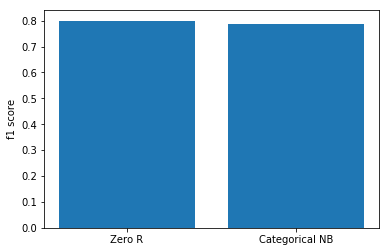

In [104]:
y = [zero_r_f1, f1_categorical_NB]
labels = ["Zero R", "Categorical NB"]

plt.bar(x=range(0, len(y)), height=y, tick_label=labels)
plt.ylabel("f1 score")
plt.show()

### Question 2\c)

- c) Explain the difference between epsilon and Laplace smoothing. [no programming required] (1 mark)
    - <font color=blue>Both of their goal is to solve the 0 probability problem (probability=0 in testing phase if we have a unseen attribute value after training). In other words, we still want the model to provide some meaningful output even though there can be some unseen feature values. Firstly, the difference is that epsilon smoothing replace 0 probability for unseen feature with a way smaller decimal number as probability in the testing phase or training phase. While laplace smoothing adds an additional </font> $\alpha$ <font color=blue>for the numerator as well as </font>$\text{#values of feature can take} * \alpha$ <font color=blue>for denominator in the training phase to avoid this problem.(can do in testing phase but generally done in training phase but with only once) Secondly, if the model has seen all possible attribute value in the training phase, then the epsilon smooth won't influence the result while laplace smooth will change the result as we modify the posterior probability by adding values to denominator and numerator.</font>

In [ ]:
#     **To sum it up, the difference is how they solve the 0 probability problem in different phases.**

## Question 3: Model Comparison

### Question 3\a)
- a) Implement the K-NN classifier, and find the optimal value for K. (1 mark)

#### preprocess data for knn

change nominal string attribute to 0, 1, 2, 3, ...

In [ ]:
stroke_df_knn = preprocess2(stroke_df)

#### split data and predict and evaluate

In [ ]:
# list of accuracy metrics result for possible k for class 0 or 1
x = []
y_acc = []
y_precision = []
y_recall = []
y_f1 = []
# y_precision = [[], []]
# y_recall = [[], []]
# y_f1 = [[], []]

# test purpose
k_range = 100
# real optimize
# k_range = int(stroke_df_knn.shape[0]*0.9 - 1)

for k in range(1, k_range):
    classifier = KNeighborsClassifier(n_neighbors=k)
    print(k)
    x.append(k)
#     k_acc, k_precision, k_recall, k_f1 = 0, [0, 0], [0, 0], [0, 0]
    k_acc, k_precision, k_recall, k_f1 = 0, 0, 0, 0
    i = 0
    for X_train, Y_train, X_test, Y_test in split_data(stroke_df_knn):        
        i += 1
        classifier.fit(X_train, np.ravel(Y_train))
        preds = classifier.predict(X_test)
        
        _, Acc, precf1 = evaluate(preds, np.ravel(Y_test))

        k_acc       += Acc
        k_precision += precf1[0]
        k_recall    += precf1[1]
        k_f1        +=precf1[2]
#         k_precision[0] += precf1[0][0]
#         k_precision[1] += precf1[0][1]
#         k_recall[0]    += precf1[1][0]
#         k_recall[1]    += precf1[1][1]
#         k_f1[0]        += precf1[2][0]
#         k_f1[1]        += precf1[2][1]
    
    k_acc       /= i
    k_precision /= i
    k_recall    /= i
    k_f1        /= i
    # averaging k-fold result
#     for j in [0, 1]:
#         k_acc          /= i
#         k_precision[j] /= i
#         k_recall[j]    /= i
#         k_f1[j]        /= i
    
    y_acc.append(k_acc)
    y_precision.append(k_precision)
    y_recall.append(k_recall)
    y_f1.append(k_f1)
#     y_precision[0].append(k_precision[0])
#     y_precision[1].append(k_precision[1])
#     y_recall[0].append(k_recall[0])
#     y_recall[1].append(k_recall[1])
#     y_f1[0].append(k_f1[0])
#     y_f1[1].append(k_f1[1])

#### plot evaluation result

In [ ]:
x1 = x[:len(y_acc)]
xrange = 300
# xrange = len(y_acc)

plt.figure(figsize=(20, 3))
plt.plot(x1[0:xrange], y_f1[0:xrange], 'y-')
plt.xlabel("k")
plt.ylabel("f1-score")
plt.title("knn optimization")
plt.show()

k maximize f1-score

In [ ]:
k_best = x[np.argmax(y_f1)]
k_best

##### for different class different accuracy metrics

In [ ]:
x1 = x[:len(y_acc)]
xrange = 300

plt.figure(figsize=(10, 10))
plt.plot(x1[0:xrange], y_acc[0:xrange], 'r-', 
         x1[0:xrange], y_precision[0][0:xrange], 'b-', 
         x1[0:xrange], y_precision[1][0:xrange], 'b--',
         x1[0:xrange], y_recall[0][0:xrange], 'g-',
         x1[0:xrange], y_recall[1][0:xrange], 'g--',
         x1[0:xrange], y_f1[0][0:xrange], 'y-',
         x1[0:xrange], y_f1[1][0:xrange], 'y--',
        )
plt.xlabel("k")
plt.legend(["accuracy", 
            "stroke: 0 precision",
            "stroke: 1 precision",
            "stroke: 0 recall",
            "stroke: 1 recall",
            "stroke: 0 f1",
            "stroke: 1 f1",
           ])
plt.show()

### Question 3\b)

- b) Based on the obtained value for K in question 4 (a), evaluate the classifier using accuracy and chosen metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline. (2 marks)

In [ ]:
x1 = []
knn_f1 = []
zero_r_f1 = []

k = k_best

# Zero-R baseline
zero_r_classifier = DummyClassifier(strategy="most_frequent")


knn_metrics = ['euclidean', 
               'manhattan'] 
#                , cosine_distances]
knn_metrics_names = ['euclidean_distance', 'manhattan_distance']
#                      , 'cosine_distance']

knn_f1, zero_r_f1 = [0 for _ in knn_metrics_names], 0

k_fold = 0
# train & test zero r
for X_train, Y_train, X_test, Y_test in split_data(stroke_df_knn):        
    k_fold += 1
    zero_r_classifier.fit(X_train, Y_train)
    preds = zero_r_classifier.predict(X_test)
    _, _, precf1 = evaluate(preds, Y_test)
    zero_r_f1 += precf1[2]
    
    for i, knn_metric in enumerate(knn_metrics):
#         print(knn_metrics_names[i])
        knn_classifier = KNeighborsClassifier(metric=knn_metric)
        
        knn_classifier.fit(X_train, np.ravel(Y_train))
        preds = knn_classifier.predict(X_test)
        _, _, precf1 = evaluate(preds, np.ravel(Y_test))
        knn_f1[i] += precf1[2]
        
zero_r_f1 /= k_fold
for i in range(0, len(knn_f1)):
    knn_f1[i] /= k_fold

In [ ]:
y = [zero_r_f1] + knn_f1
labels = ["Zero R"] + knn_metrics_names

plt.bar(x=range(0, len(y)), height=y, tick_label=labels)
plt.ylabel("f1 score")
plt.show()

### Question 3\c)

- c) Is K-NN sensitive to imbalanced data? Justify your answer. [no programming required]

- d) Compare the classifiers (Naive Bayes and K-NN) based on metrics' results. Provide a comparatory discussion on the results. [no programming required] (1 mark)

# End